#MLivin' It
##Welcome to MLivin' It. The app engineering productive health, anytime, anywhere.

Here, you'll find the implementation of our DCNN Resnet-18 model used to perform image classification of pictures taken from your very own phone gallery. In this implementation, we tackle a small-scale multiclass classification problem with 5 different foods:
- nasi lemak
- omu rice
- fried chicken
- chicken porridge
- chicken rice

We employ a transfer learning approach to tackle the challenge of starting with a small input dataset, and achieve a very decent 93% accuracy with our vaildation set! 

# imports

In [ ]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import os
import copy
import pickle
import itertools
import cv2 as cv
import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import sklearn as skl
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
import scipy.stats as ss

from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

plt.ion()   # interactive mode

from google.colab import drive
drive.mount('gdrive/', force_remount=True)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at gdrive/


# dataset

## loading in

In [ ]:
# Data augmentation and normalization for training
# G R A Y S C A L E

data_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

dataset = datasets.ImageFolder(root='/content/gdrive/My Drive/hackerthon_test', transform=data_transform)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)
print(torch.cuda.get_device_name(0))

# https://discuss.pytorch.org/t/how-to-use-sklearns-train-test-split-on-pytorchs-dataset/31521
# Obtain train and test indexes
targets = dataset.targets

train_idx, test_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, shuffle=True, stratify=targets)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.2, shuffle=True, stratify=[targets[i] for i in train_idx])

print("all", np.unique(np.array(targets), return_counts=True))
print("train", np.unique(np.array(targets)[train_idx], return_counts=True))
print("val", np.unique(np.array(targets)[val_idx], return_counts=True))
print("test", np.unique(np.array(targets)[test_idx], return_counts=True))

# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

#dataloaders = {x: torch.utils.data.DataLoader(dataset, sampler=x, batch_size=1, num_workers=4) for x in ['train', 'val']}
b_size = 8

dataloaders = {
  "train": torch.utils.data.DataLoader(datasets.ImageFolder(root='/content/gdrive/My Drive/hackerthon_test', transform=data_transforms['train']), sampler=train_sampler, batch_size=b_size, num_workers=4),
  "val": torch.utils.data.DataLoader(datasets.ImageFolder(root='/content/gdrive/My Drive/hackerthon_test', transform=data_transforms['val']), sampler=val_sampler, batch_size=b_size, num_workers=4),
  "test": torch.utils.data.DataLoader(datasets.ImageFolder(root='/content/gdrive/My Drive/hackerthon_test', transform=data_transforms['val']), sampler=test_sampler, batch_size=b_size, num_workers=4),
}
#dataset_sizes = {x: len(dataloaders[x])*b_size for x in ['train', 'val']}
dataset_sizes = {
    "train": len(train_idx),
    "val": len(val_idx),
    "test": len(test_idx)}

class_names=dataset.classes
dataset_sizes

cuda:0
Tesla P4
all (array([0, 1, 2, 3, 4]), array([25, 50, 25, 25, 26]))
train (array([0, 1, 2, 3, 4]), array([16, 32, 16, 16, 16]))
val (array([0, 1, 2, 3, 4]), array([4, 8, 4, 4, 4]))
test (array([0, 1, 2, 3, 4]), array([ 5, 10,  5,  5,  6]))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'test': 31, 'train': 96, 'val': 24}

# methods

In [ ]:
# ------------------------------------------- #
# IMAGE SHOW

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# ------------------------------------------- # 
# TRAIN MODEL
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    all_train = []
    all_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # append history to logs
            if phase == 'train':
              all_train.append((epoch_loss, epoch_acc))
            else:
              all_val.append((epoch_loss, epoch_acc)) 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))   

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc, (all_train, all_val)

# ------------------------------------------- #
# VISUALIZE MODEL
def visualize_model(model, num_images=10, mode ='val'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    for params in model.parameters():
      params.requires_grad = False # Freeze all weights

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[mode]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.figure()
                plt.axis('off')
                plt.title('predicted: {}, actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# ------------------------------------------- #
# OBTAIN PREDICTIONS
def pred_model(model, predtype = 'val'):
    was_training = model.training
    model.eval()

    all_labels=[]
    all_preds=[]
    all_probs=[]

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[predtype]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            p = torch.nn.functional.softmax(outputs, dim=1)

            all_labels.append(labels)
            all_preds.append(preds)
            all_probs.append(p)

        model.train(mode=was_training)
        return all_labels, all_preds, all_probs

# ------------------------------------------- #
# SAVE MODEL
def savemodel(filename, model, best_acc, logs, hyparam = [], mode='norm'):
  if mode == 'optim':
    best_acc = np.round(best_acc.cpu().numpy(),3)
    print(best_acc)
    filepath_model = '/content/gdrive/My Drive/hackerthon_test/' + filename + '_' + str(best_acc) + '_model.pth'
    torch.save(model.state_dict(), filepath_model)

    filepath_logs='/content/gdrive/My Drive/hackerthon_test/' + filename + '_' + str(best_acc) + '.pkl'
    with open(filepath_logs, 'wb') as f:
      pickle.dump([best_acc, logs], f)

    filepath_logs='/content/gdrive/My Drive/hackerthon_test/' + filename + '_' + str(best_acc) + '_hyparams.pkl'
    with open(filepath_logs, 'wb') as f:
      pickle.dump(hyparam, f)

  else:
    best_acc = np.round(best_acc.cpu().numpy(),3)
    print(best_acc)
    filepath_model = '/content/gdrive/My Drive/hackerthon_test/' + filename + '_' + str(best_acc) + '_model.pth'
    torch.save(model.state_dict(), filepath_model)

    filepath_logs='/content/gdrive/My Drive/hackerthon_test/' + filename + '_' + str(best_acc) + '.pkl'
    with open(filepath_logs, 'wb') as f:
      pickle.dump([best_acc, logs], f)

# OPEN MODEL
def openfile(filename):
  filepath='/content/gdrive/My Drive/hackerthon_test/' + filename + '.pkl'
  with open(filepath, 'rb') as f:
      [best_acc, logs] = pickle.load(f)

  return best_acc, logs

# ------------------------------------------- #
# MULTICLASS ROC

def plot_multiclass_roc(y_prob, y_test, n_classes, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = skm.roc_curve(y_test[:, i], y_prob[:, i])
        roc_auc[i] = skm.auc(fpr[i], tpr[i])

    ## Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = skm.roc_curve(y_test.ravel(), y_prob.ravel())
    roc_auc["micro"] = skm.auc(fpr["micro"], tpr["micro"])

    ## Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = skm.auc(fpr["macro"], tpr["macro"])

    ## ROC for each class
    colors = itertools.cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', alpha=.8)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve (Accuracy = %0.2f)' % skm.accuracy_score(val_label2, val_pred2))
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]), color='gold', linestyle=':', linewidth=2)
    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]), color='salmon', linestyle=':', linewidth=2)
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, label='ROC curve (area = %0.2f) for class [%s]' % (roc_auc[i], class_names[i]))
    ax.legend(loc="lower right")
    ax.grid(alpha=.4)
    sns.despine()
    plt.savefig('multiroc.tiff', dpi=400)

# MULTICLASS PRECISION RECALL
def plot_multiclass_precrec(Y_test, y_score, kappa_score, mcc_score):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    n_classes = len(Y_test[0])
    for i in range(n_classes):
        precision[i], recall[i], _ = skm.precision_recall_curve(Y_test[:, i],
                                                            y_score[:, i])
        average_precision[i] = skm.average_precision_score(Y_test[:, i], y_score[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = skm.precision_recall_curve(Y_test.ravel(),
        y_score.ravel())
    average_precision["micro"] = skm.average_precision_score(Y_test, y_score,
                                                        average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'
          .format(average_precision["micro"]))

    plt.figure()
    plt.step(recall['micro'], precision['micro'], where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(average_precision["micro"]))

    # setup plot details
    colors = itertools.cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plt.figure(figsize=(7, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                  ''.format(average_precision["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class [{0}] (area = {1:0.2f})'
                      ''.format(class_names[i], average_precision[i]))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall curve (\u03BA = %0.3f, MCC = %0.3f)' % (kappa_score, mcc_score))
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))

    plt.savefig('precrec.tiff', dpi=400)

# ------------------------------------------- #
# FEATURE MAPS
def show_featuremap(model):
  model_weights = [] # we will save the conv layer weights in this list
  conv_layers = [] # we will save the 49 conv layers in this list
  # get all the model children as list
  model_children = list(model.children())

  # counter to keep count of the conv layers
  counter = 0 
  # append all the conv layers and their respective weights to the list
  for i in range(len(model_children)):
      if type(model_children[i]) == nn.Conv2d:
          counter += 1
          model_weights.append(model_children[i].weight)
          conv_layers.append(model_children[i])
      elif type(model_children[i]) == nn.Sequential:
          for j in range(len(model_children[i])):
              for child in model_children[i][j].children():
                  if type(child) == nn.Conv2d:
                      counter += 1
                      model_weights.append(child.weight)
                      conv_layers.append(child)
  print(f"Total convolutional layers: {counter}")

  # take a look at the conv layers and the respective weights
  for weight, conv in zip(model_weights, conv_layers):
      # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
      print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

  # visualize the first conv layer filters
  plt.figure(figsize=(20, 17))
  for i, filter in enumerate(model_weights[0]):
      plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
      plt.imshow(filter[0, :, :].cpu().detach(), cmap='gray')
      plt.axis('off')
      # plt.savefig('../outputs/filter.png')
  
  plt.savefig('featmap.tiff', dpi=400)

def show_featuremap_img(model, imgdir, imgname):
    # initializing model

    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the 49 conv layers in this list
    # get all the model children as list
    model_children = list(model.children())

    # counter to keep count of the conv layers
    counter = 0 
    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
        elif type(model_children[i]) == nn.Sequential:
            for j in range(len(model_children[i])):
                for child in model_children[i][j].children():
                    if type(child) == nn.Conv2d:
                        counter += 1
                        model_weights.append(child.weight)
                        conv_layers.append(child)
    print(f"Total convolutional layers: {counter}")
    
    # read and visualize an image
    img = cv.imread(imgdir)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    # define the transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    img = np.array(img)
    # apply the transforms
    img = transform(img)
    print(img.size())
    # unsqueeze to add a batch dimension
    img = img.unsqueeze(0)
    print(img.size())


    # pass the image through all the layers
    results = [conv_layers[0](img.cuda())]
    for i in range(1, len(conv_layers)):
        # pass the result from the last layer to the next layer
        results.append(conv_layers[i](results[-1]))
    # make a copy of the `results`
    outputs = results

    # visualize 64 features from each layer 
    # (although there are more feature maps in the upper layers)
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(30, 30))
        layer_viz = outputs[num_layer][0, :, :, :]
        layer_viz = layer_viz.data
        print(layer_viz.size())
        for i, filter in enumerate(layer_viz):
            if i == 64: # we will visualize only 8x8 blocks from each layer
                break
            plt.subplot(8, 8, i + 1)
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")

        print(f"Saving layer {num_layer} feature maps...")
        images_dir = '/content/gdrive/My Drive/Images_sorted_2/output'
        plt.savefig(f"{images_dir}/{imgname}_layer_{num_layer}.png")
        # plt.show()
        plt.close()

    print("All layers saved")


## checking dataloader sets

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


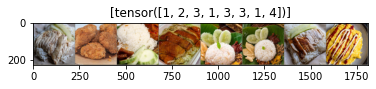

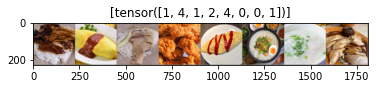

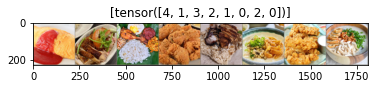

In [ ]:
import warnings

# ------------------------------------------- #
# CHECK IMAGES IN VALIDATION SET
warnings.filterwarnings("ignore", "(Possibly )?corrupt EXIF data", UserWarning)

for i, (inputs, labels) in enumerate(dataloaders['val']):
  out = torchvision.utils.make_grid(inputs)
  imshow(out, title=[labels])

# models

## Model Training w ResNet18

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optim_name = "SGD"
learn_rate = 0.0002
momen = 0.9
step_sz = 7
gam = 0.1

hyparams = [optim_name, learn_rate, momen, step_sz, gam]
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learn_rate, momentum=momen) # stochastic gradient descent optimizer
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=learn_rate, weight_decay=1e-5) # L2 Regularization

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=step_sz, gamma=gam)

# SGD optimizer
model_ft, best_acc_ft, logs_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)
print('{time}-ft_BW_REVISED_34_{acc}'.format(time=datetime.now().strftime('%H:%M'), acc=best_acc_ft))
# savemodel('{time}-ft_BW_REVISED_34'.format(time=datetime.now().strftime('%H:%M:%S')), model_ft, best_acc_ft, logs_ft)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.7179 Acc: 0.1875
val Loss: 1.4778 Acc: 0.2917

Epoch 1/49
----------
train Loss: 1.4505 Acc: 0.3646
val Loss: 1.2360 Acc: 0.4167

Epoch 2/49
----------
train Loss: 1.2337 Acc: 0.5208
val Loss: 1.0297 Acc: 0.6667

Epoch 3/49
----------
train Loss: 1.0319 Acc: 0.6875
val Loss: 0.8606 Acc: 0.7500

Epoch 4/49
----------
train Loss: 0.8708 Acc: 0.8333
val Loss: 0.7187 Acc: 0.8750

Epoch 5/49
----------
train Loss: 0.7385 Acc: 0.8333
val Loss: 0.6235 Acc: 0.8750

Epoch 6/49
----------
train Loss: 0.7021 Acc: 0.8542
val Loss: 0.5581 Acc: 0.9167

Epoch 7/49
----------
train Loss: 0.6235 Acc: 0.8646
val Loss: 0.5589 Acc: 0.9167

Epoch 8/49
----------
train Loss: 0.6047 Acc: 0.8750
val Loss: 0.5536 Acc: 0.9167

Epoch 9/49
----------
train Loss: 0.6431 Acc: 0.8750
val Loss: 0.5492 Acc: 0.9167

Epoch 10/49
----------
train Loss: 0.6529 Acc: 0.8646
val Loss: 0.5389 Acc: 0.9167

Epoch 11/49
----------
train Loss: 0.5928 Acc: 0.9479
val Loss: 0.5238 Acc: 0.9167

Epoch 12/49
----------
t

NameError: ignored

In [ ]:
from datetime import datetime

best_acc_ft=torch.from_numpy(np.array(best_acc_ft.cpu())).float().cuda()

print('model_{acc}'.format(acc=best_acc_ft))
savemodel('{time}-model'.format(time=datetime.now().strftime('%H:%M')), model_ft, best_acc_ft, logs_ft, hyparam = hyparams, mode='optim')

model_0.9583333134651184
0.958


0.9583333333333333 12


<Figure size 432x288 with 0 Axes>

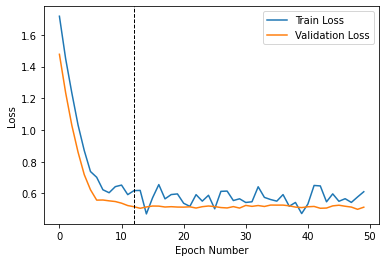

<Figure size 432x288 with 0 Axes>

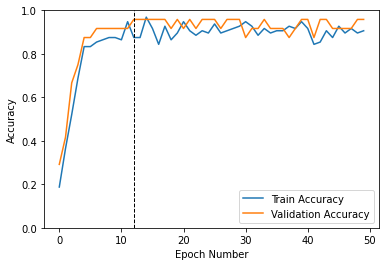

In [ ]:
train_loss = [i[0] for i in logs_ft[0]]
train_acc = np.array([i[1].cpu().numpy() for i in logs_ft[0]])
val_loss = [i[0] for i in logs_ft[1]]
val_acc = np.array([i[1].cpu().numpy() for i in logs_ft[1]])

bestmod=np.argmax(val_acc)
print(val_acc[bestmod],bestmod)

fig_loss = plt.figure()

plt.figure()
plt.plot(train_loss,label="Train Loss")
plt.plot(val_loss,label="Validation Loss")
plt.axvline(np.argmax(val_acc), color='k', linestyle='dashed', linewidth=1)
plt.legend()
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.savefig('{time}-test-{acc}.tiff'.format(time=datetime.now().strftime('%H:%M'),acc=round(val_acc[bestmod],3)), dpi=400)

fig_acc = plt.figure()
plt.figure()
plt.plot(train_acc,label="Train Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.axvline(np.argmax(val_acc), color='k', linestyle='dashed', linewidth=1)
plt.legend(loc='lower right')
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.ylim([0,1])
plt.savefig('{time}-test_{acc}.tiff'.format(time=datetime.now().strftime('%H:%M'),acc=round(val_acc[bestmod],3)), dpi=400)

In [ ]:
current_model=model_ft

# ------------------------------------------- #
val_label, val_pred, val_p = pred_model(current_model,'test')
# val_label, val_pred, val_p = pred_model(current_model) # check validation
# visualize_model(current_model)

val_pred2 = torch.flatten(torch.cat(val_pred)).cpu()
val_label2 = torch.flatten(torch.cat(val_label)).cpu()
val_p2 = torch.cat(val_p).cpu().numpy()

print(skm.accuracy_score(val_label2, val_pred2))

print(len(val_label2))
print(len(val_pred2))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8709677419354839
31
31


# analyze models

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 432x288 with 0 Axes>

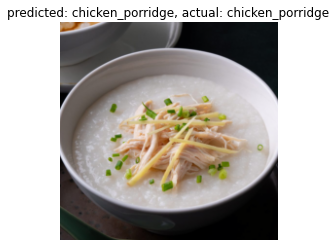

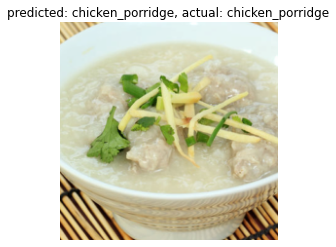

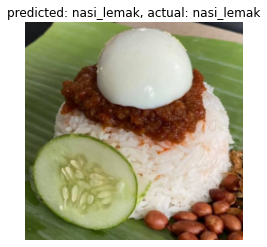

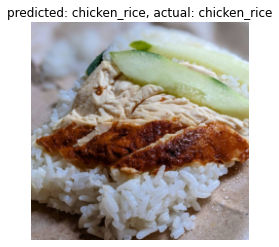

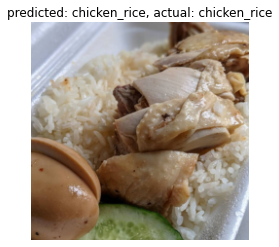

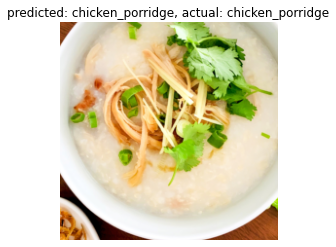

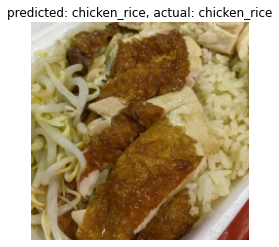

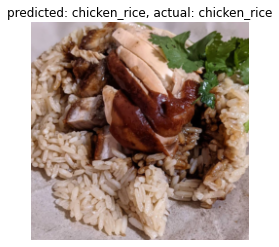

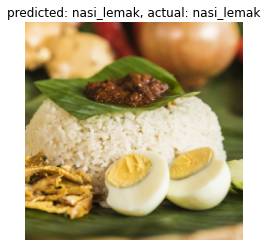

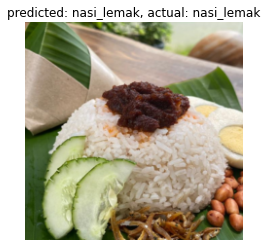

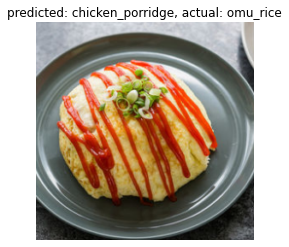

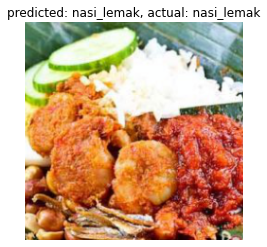

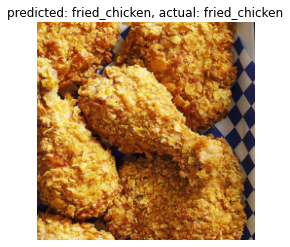

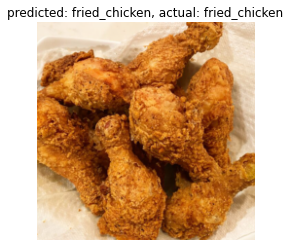

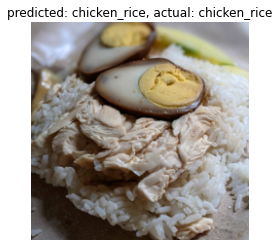

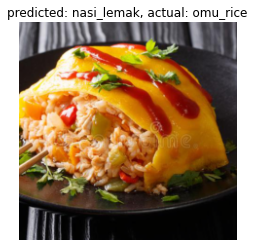

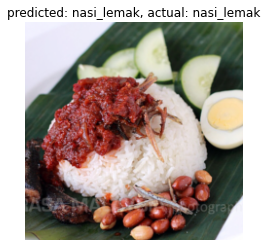

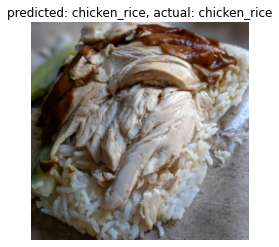

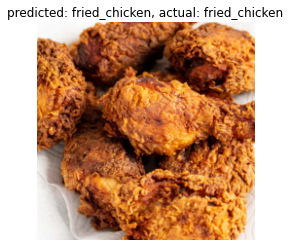

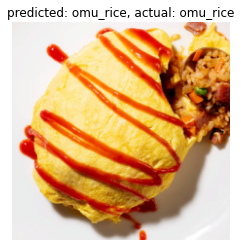

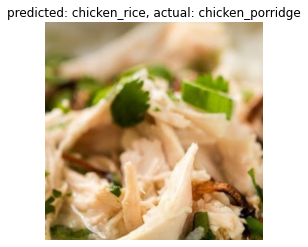

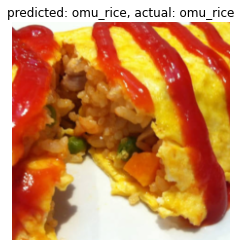

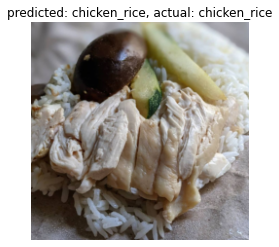

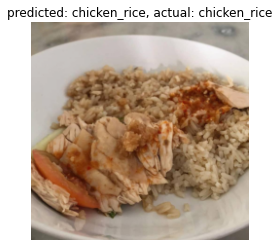

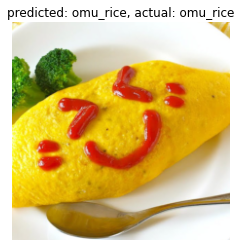

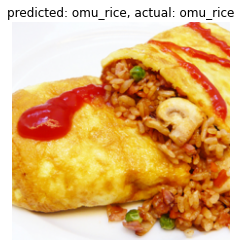

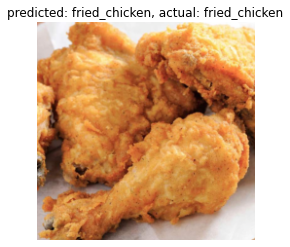

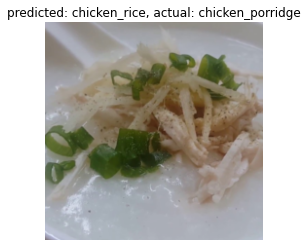

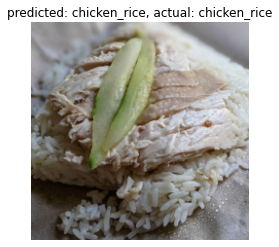

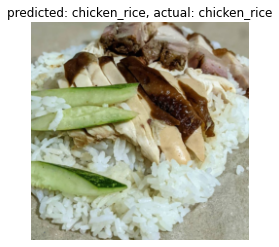

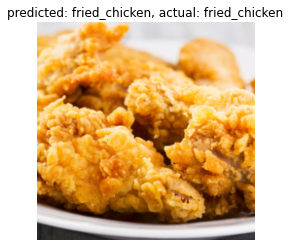

In [ ]:
visualize_model(model_ft, 31, 'test')

In [ ]:
best_acc_ft, logs_ft = openfile('ft_BW_KEEP_18_0.833')

Confusion matrix, without normalization
[[ 3  2  0  0  0]
 [ 0 10  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0  5  0]
 [ 1  0  0  1  4]]
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.83      1.00      0.91        10
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      0.67      0.80         6

    accuracy                           0.87        31
   macro avg       0.88      0.85      0.86        31
weighted avg       0.88      0.87      0.86        31



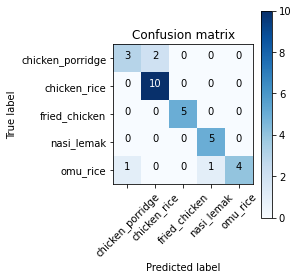

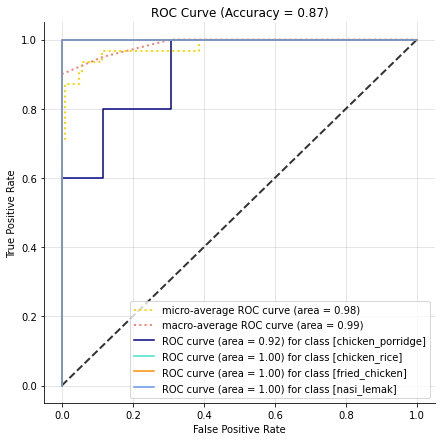

In [ ]:
# ------------------------------------------- #
# actual plotting

stacked = torch.stack((val_label2, val_pred2),dim=1)
cmt = torch.zeros(len(class_names),len(class_names), dtype=torch.int64)

for p in stacked:
  t1, p1 = p.tolist()
  cmt[t1,p1] = cmt[t1,p1] + 1

cm = skm.confusion_matrix(val_label2, val_pred2)

plt.figure(figsize=(4,4))
plot_confusion_matrix(cm, class_names)

val_label_mc, val_pred_mc = np.zeros((len(val_label2),len(class_names))), val_p2

for i in range(len(val_label2)):
  val_label_mc[i,val_label2[i].numpy()] = 1

plot_multiclass_roc(val_pred_mc, val_label_mc, n_classes=4, figsize=(7, 7))

print(skm.classification_report(val_label2,val_pred2))

Average precision score, micro-averaged over all classes: 0.98


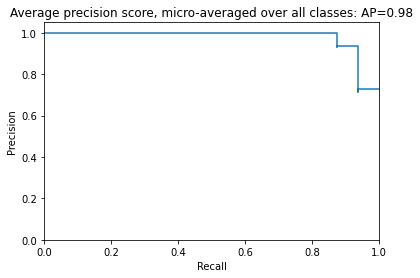

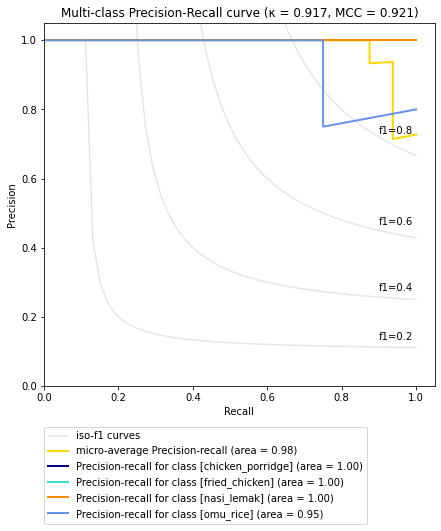

In [ ]:
kappa_score = skm.cohen_kappa_score(val_label2, val_pred2)
mcc_score = skm.matthews_corrcoef(val_label2,val_pred2)
plot_multiclass_precrec(val_label_mc, val_pred_mc, kappa_score, mcc_score)

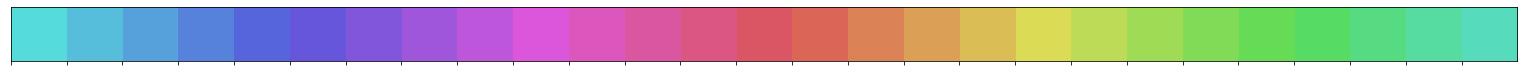

In [ ]:
sns.palplot(sns.hls_palette(27, h=.5))

# file IO

## saving model

In [ ]:
savemodel('ft', model_ft, best_acc_ft, logs_ft)

0.733


## open model

In [ ]:
best_acc_ft, logs_ft = openfile('ft_BW_3_0.8')

# LOAD MODEL
model1 = models.resnet18(pretrained=True)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, len(class_names))
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

model1.load_state_dict(torch.load('/content/gdrive/My Drive/hackerthon_test/ft_model.pth'))
model1 = model1.to(device)
model1.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  